#  Predicting Financial Fraud

Preventing financial fraud is a critical concern for financial institutions as it can cause significant losses for both the institution and its customers. Predicting fraudulent activities can help banks and financial institutions develop more effective risk management strategies, such as strengthening their security measures, identifying high-risk accounts, and implementing fraud detection tools.

Using machine learning algorithms, financial institutions can analyze a wide range of factors, such as transaction history, account activity, and customer behavior, to detect patterns that may indicate fraudulent activity. With Gradient Boosting algorithms, we can create a predictive model that can accurately identify fraudulent transactions, helping institutions take proactive measures to prevent financial losses.

# 1. Importing Libraries and Initial Evaluation

To initiate our analysis, we need to import the relevant libraries for data processing, visualization, and machine learning model creation, and rename some columns and categories to ensure the data is understandable. For more details about each column, please refer to the dataset's Kaggle page.

Before building the model, it's essential to evaluate and comprehend the dataset's characteristics, such as missing values, outliers, and data distributions. By doing so, we can detect potential issues with the dataset and make any necessary adjustments to improve the model's accuracy and efficiency. Ensuring the quality and robustness of the final model is critical, and this step is vital in achieving that.

In [1]:
import numpy as np # linear algebra
import pandas as pd # Data processing
import matplotlib.pyplot as plt #Data visualization
import seaborn as sns # Data visualization
from sklearn.model_selection import train_test_split, RandomizedSearchCV # Cross-validation, splitting sets
from sklearn.preprocessing import MinMaxScaler #Data scaling
import xgboost as xgb #Extreme Gradient Boosting
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score #Metrics
import matplotlib.ticker as mticker # Label format 
from matplotlib.ticker import ScalarFormatter # Label format
from matplotlib.ticker import FuncFormatter
from sklearn.impute import SimpleImputer

#Creating the Dataframe
frauds_df = pd.read_csv('/kaggle/input/paysim1/PS_20174392719_1491204439457_log.csv')

frauds_df.rename(columns={'type':'Type', 
                  'amount':'Amount', 
                  'nameOrig':'Customer ID', 
                  'oldbalanceOrg':'Customer Before', 
                  'newbalanceOrig':'Customer After', 
                  'nameDest': 'Destination ID',
                  'oldbalanceDest': 'Destination Before',
                  'newbalanceDest': 'Destination After',
                  'isFraud':'Fraud',
                  'isFlaggedFraud':'Flagged'},
                  inplace=True)

frauds_df['Customer Type'] = frauds_df['Customer ID'].str.split('\d+', expand=True, n=1)[0]
frauds_df['Destination Type'] = frauds_df['Destination ID'].str.split('\d+', expand=True, n=1)[0]

frauds_df['Type'].replace({'CASH_OUT':'Cash Out',
                           'PAYMENT':'Payment',
                           'CASH_IN':'Cash In',
                           'TRANSFER':'Transfer', 
                           'DEBIT':'Debit'},
                           inplace=True)

frauds_df[['Type', 
           'Customer Type', 
           'Destination Type']] = frauds_df[['Type', 
                                             'Customer Type', 
                                             'Destination Type']].astype('category')

frauds_df[['Fraud', 
           'Flagged']] = frauds_df[['Fraud', 
                                    'Flagged']].astype('bool')

display(frauds_df.describe(include='all'))

display('Missing Values:')
display(frauds_df.isna().sum())

display('Data Format:')
display(frauds_df.info())

,step,Type,Amount,Customer ID,Customer Before,Customer After,Destination ID,Destination Before,Destination After,Fraud,Flagged,Customer Type,Destination Type
count,6.362620e+06,6362620,6.362620e+06,6362620,6.362620e+06,6.362620e+06,6362620,6.362620e+06,6.362620e+06,6362620,6362620,6362620,6362620
unique,NaN,5,NaN,6353307,NaN,NaN,2722362,NaN,NaN,2,2,1,2
top,NaN,Cash Out,NaN,C1902386530,NaN,NaN,C1286084959,NaN,NaN,False,False,C,C
freq,NaN,2237500,NaN,3,NaN,NaN,113,NaN,NaN,6354407,6362604,6362620,4211125
mean,2.433972e+02,NaN,1.798619e+05,NaN,8.338831e+05,8.551137e+05,NaN,1.100702e+06,1.224996e+06,NaN,NaN,NaN,NaN
std,1.423320e+02,NaN,6.038582e+05,NaN,2.888243e+06,2.924049e+06,NaN,3.399180e+06,3.674129e+06,NaN,NaN,NaN,NaN
min,1.000000e+00,NaN,0.000000e+00,NaN,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN
25%,1.560000e+02,NaN,1.338957e+04,NaN,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN
50%,2.390000e+02,NaN,7.487194e+04,NaN,1.420800e+04,0.000000e+00,NaN,1.327057e+05,2.146614e+05,NaN,NaN,NaN,NaN
75%,3.350000e+02,NaN,2.087215e+05,NaN,1.073152e+05,1.442584e+05,NaN,9.430367e+05,1.111909e+06,NaN,NaN,NaN,NaN


'Missing Values:'

step                  0
Type                  0
Amount                0
Customer ID           0
Customer Before       0
Customer After        0
Destination ID        0
Destination Before    0
Destination After     0
Fraud                 0
Flagged               0
Customer Type         0
Destination Type      0
dtype: int64

'Data Format:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 13 columns):
 #   Column              Dtype   
---  ------              -----   
 0   step                int64   
 1   Type                category
 2   Amount              float64 
 3   Customer ID         object  
 4   Customer Before     float64 
 5   Customer After      float64 
 6   Destination ID      object  
 7   Destination Before  float64 
 8   Destination After   float64 
 9   Fraud               bool    
 10  Flagged             bool    
 11  Customer Type       category
 12  Destination Type    category
dtypes: bool(2), category(3), float64(5), int64(1), object(2)
memory usage: 418.7+ MB


None

# 2. Defining Helper Functions

Within this notebook, I have created a few helper functions that serve to facilitate the creation of visualizations and improve the overall readability of the code. These functions were necessary to streamline the visualization process for model results.

By defining these helper functions, I was able to simplify the process of creating complex visualizations, enabling me to spend less time writing code and more time analyzing the data. Additionally, the functions serve to make the code more modular and easier to understand by breaking down complex tasks into smaller, more manageable pieces. Without them, the visualization process would be more cumbersome and time-consuming.

You may notice some of these functions are very similar to the ones I developed earlier for my <a href="https://www.kaggle.com/code/leandrocassius/predicting-defaults-with-xgb">defaults notebook</a>, since in both cases we are using a classification model with an imbalanced dataset.

In [2]:
def my_catplot(feature=None, ax=None):
    sns.countplot(data=frauds_df[:100000], x=feature, hue='Fraud', palette=(palette[0], palette[-1]), ax=ax)
    ax.set_xlabel('Number of Observations')
    ax.set_ylabel(f'{feature}')

def my_histplot(feature=None, ax=None):
    sns.histplot(data=frauds_df[:100000], 
                         x=feature, 
                         hue='Fraud', 
                         kde=True, 
                         element='step', 
                         palette=(palette[0], 
                                  palette[-1]), 
                         ax=ax,
                         log_scale=True)
    ax.set_ylabel('Number of Observations')
    ax.set_xlabel(f'{feature}')
    mean_value_f = frauds_df[frauds_df['Fraud']==False][feature].mean()
    mean_value_t = frauds_df[frauds_df['Fraud']==True][feature].mean()
    ax.axvline(x=mean_value_f, 
               color=palette[0])
    ax.axvline(x=mean_value_t, 
                color=palette[-1])
    ax.annotate(f'Mean {feature}\n for regular transactions: ${mean_value_f:,.2f}', 
                 xy=(0.1, 0.5),
                 xycoords='axes fraction',
                 font='roboto',
                 fontstyle='italic')
    ax.annotate(f'Mean {feature}\n for fraudulent transactions: ${mean_value_t:,.2f}', 
                 xy=(0.1, 0.3),
                 xycoords='axes fraction',
                 font='roboto',
                 fontstyle='italic')
    
def cm_auc_vis(y_test, y_pred, probs):
    #Creating f1-score
    f1 = f1_score(y_test, y_pred)
    #Creating ROC curve
    fallout, sensitivity, thresholds = roc_curve(y_test, probs[:, 1])
    #Computing the ROC AUC score
    auc = roc_auc_score(y_test, probs[:, 1])
    # Plot the ROC curve and confusion matrix for this model
    sns.set_style('white')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    fig.suptitle(f'ROC AUC Score & Confusion Matrix \n ROC AUC Score: {auc:.4%} \n F1-Score: {f1:.4%}', fontsize=16, font='Verdana')
    sns.lineplot(x=fallout, y=sensitivity, ax=ax1, color=palette[-1])
    ax1.axline(xy1=[0, 0], xy2=[1, 1], linestyle='--', color=palette[0])
    ax1.set_xlabel('Fallout')
    ax1.set_ylabel('Sensitivity')
    #Creating Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='all', ax=ax2, cmap='RdGy_r', values_format=',.4%')

    plt.show()

# 3. Creating Visualizations (EDA)

By creating visualizations such as histograms, scatter plots, and box plots, we can gain a more profound understanding of the data's distribution and patterns, allowing us to identify any potential issues such as skewness or outliers.

Outliers are data points that deviate significantly from the rest of the dataset and can have a major impact on the accuracy of the fraud detection model. Therefore, it's crucial to identify and address them early on to ensure that the final model is robust and reliable.

The non-null count on the table earlier indicates that there are no missing values in the dataset. This allows me to proceed with the critical step of checking the data for errors or outliers through a few visualizations that will help understand better how the data is shaped.

*The dataset contains over 6 million rows of transactions, so I decided to use only the first 100,000 transactions for the visualizations to speed things up*

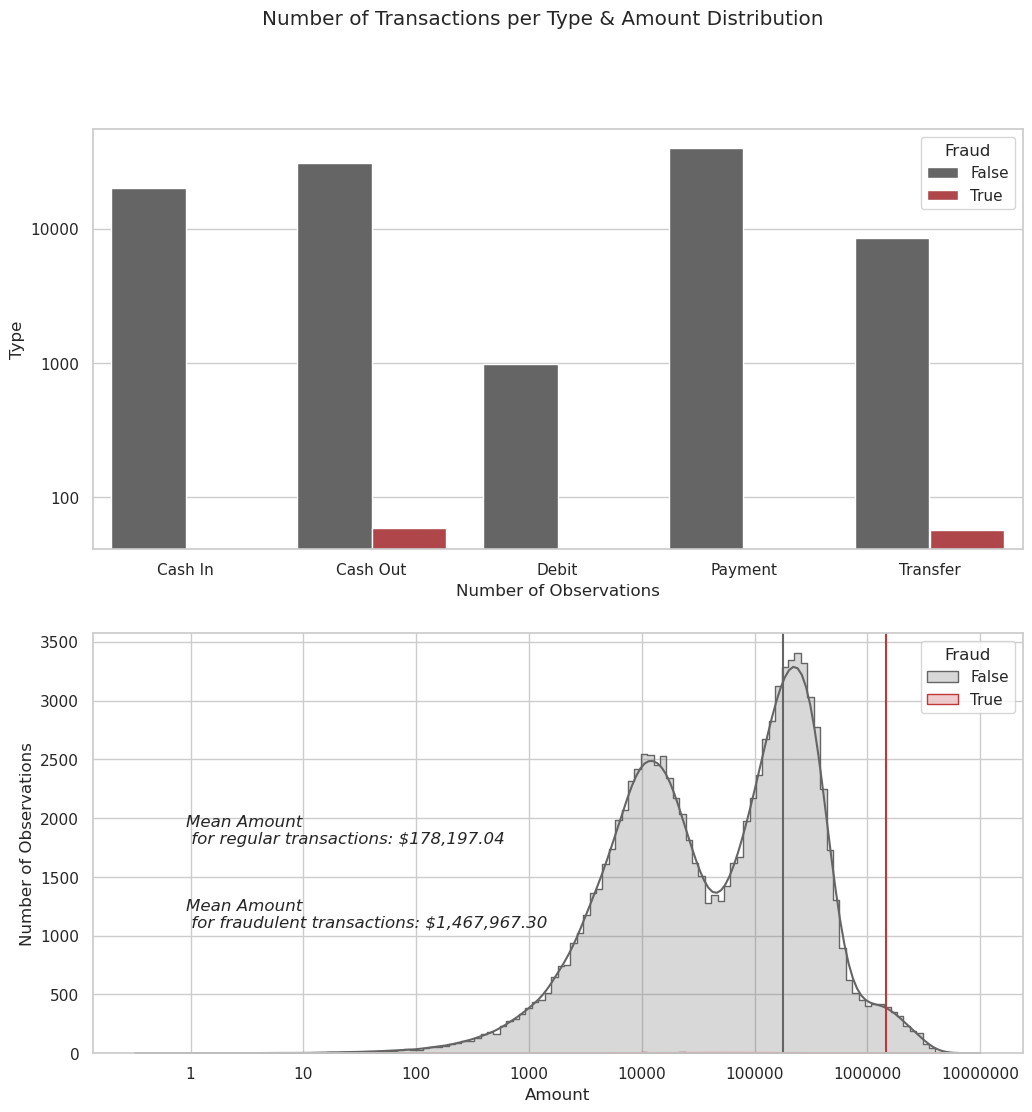

In [3]:
#Setting styles for charts
sns.set_style('whitegrid')
sns.set_context('notebook')
sns.set_palette('RdGy_r')

palette = sns.color_palette('RdGy_r')

#Creating visualizations
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
fig.suptitle('Number of Transactions per Type & Amount Distribution')

my_catplot('Type', ax1)
ax1.set_yscale('log')
ax1.yaxis.set_major_formatter(mticker.ScalarFormatter())

my_histplot('Amount', ax2)
ax2.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax2.ticklabel_format(style='plain', axis='x')


plt.show()

With these visualizations, we have noticed that:

* Most fraudulent transactions occur in the categories Cash-Out & Transfer, which is quite logical;
* The mean amount of fraudulent transactions is much higher than the mean amount of regular transactions;
* The dataset is quite imbalanced, which is common for financial fraud detection, but can be harder to tune the model for.

# 4. Predicting Financial Fraud with Extreme Gradient Boost

XGBoost is a powerful machine learning algorithm that has proven to be effective for binary classification problems, such as predicting fraudulent transactions.

In this scenario, we will train the model on the dataset after it has been preprocessed. The preprocessing in this case will include adding columns with log-adjusted values, dropping columns that are not relevant or might cause data leakage, imputing values, and standardizing them. 

### Making Log Values

* Log values can help standardize skewed data, which is often the case of financial transactions. This might add a performance boost to the model.
    
### Irrelevant Columns

* Columns such as “Customer ID” and “Flagged” might be misinterpreted by the model. For example, using the column “Flagged” in the model might lead to data leakage, that means the model will be getting information about fraudulent transactions by actually knowing which transactions are fraudulent. We don't want this to happen. 
    
### Imputing & Standardizing Values

* Although we have confirmed that there are no missing values in the dataset earlier, some data might still need to be imputed. Standardizing them further helps the model process the information better, which leads to a better accuracy.

Once we have done all this, we will then try to optimize the model using techniques such as scaling and cross-validation to ensure the best performance. The results of the model can be used to make informed decisions regarding transaction authorization, balancing the trade-off between accuracy and financial risk.

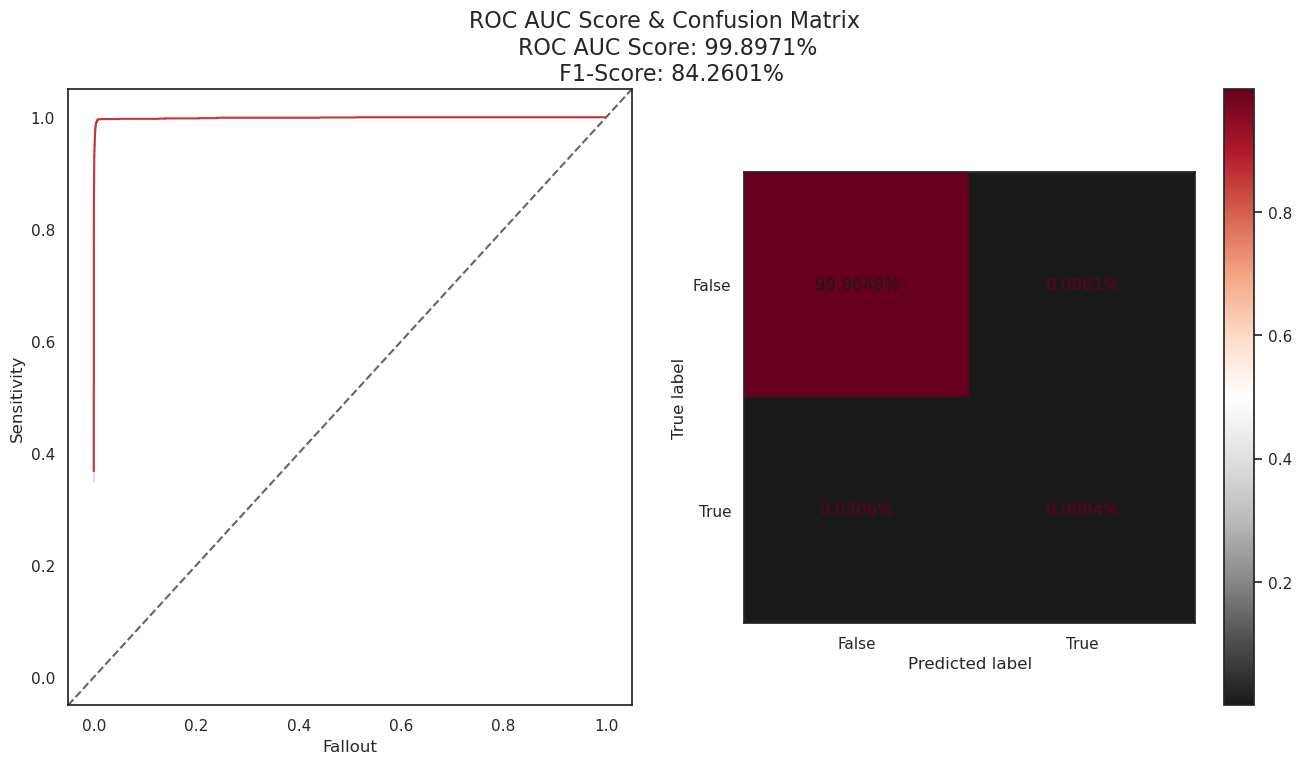

In [4]:
frauds_df.drop(columns=['Flagged', 'Customer ID', 'Destination ID'], inplace=True)

frauds_df[['Amount (Log)', 
           'Customer Before (Log)', 
           'Customer After (Log)', 
           'Destination Before (Log)',
           'Destination After (Log)']] = frauds_df[['Amount', 
           'Customer Before', 
           'Customer After', 
           'Destination Before',
           'Destination After']].apply(np.log1p)

sns.set_style('white')

frauds_df = pd.get_dummies(frauds_df)

X = frauds_df.copy()
y = X.pop('Fraud')

simp = SimpleImputer()
X_imputed = simp.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, train_size=0.7, stratify=y)

mms = MinMaxScaler()

scaled_X_train = mms.fit_transform(X_train)
scaled_X_test= mms.fit_transform(X_test)

# Initiating Model
gbt = xgb.XGBClassifier(objective='binary:logistic',
                        learning_rate=0.1,
                        random_state=42,
                        tree_method='gpu_hist',
                        early_stopping_rounds=5,
                        gamma=0.1,
                        min_child_weight=2,
                        subsample=0.1,
                        sampling_method='gradient_based',
                        reg_lambda=2)

gbt.fit(scaled_X_train, y_train, eval_set=[(scaled_X_test, y_test)], verbose=False)

# Creating predictions

y_pred = gbt.predict(scaled_X_test)
probs = gbt.predict_proba(scaled_X_test)

# Visualizing with helper function
cm_auc_vis(y_pred=y_pred, y_test=y_test, probs=probs)

# 5. Model Results

After having processed around 6 million rows of data, we can say that the model is very accurate in identifying fraud, though there is a significant amount of mislabeled fraudulent transactions. 

We can try undersampling the model so that the training dataset is more balanced. It might help improve the accuracy in the test dataset.

# 6. Modifying Thresholds 

In order to optimize the accuracy of a fraud detection model, it may be necessary to adjust the model thresholds. By adjusting the threshold, it is possible to balance the trade-off between identifying as many fraudulent transactions as possible while minimizing the number of false positives. In many cases, a more stringent threshold can improve model accuracy without significantly affecting the identification of regular transactions. Given the impact of fraud on businesses and their customers, optimizing the model threshold is an important step in ensuring the effectiveness and efficiency of fraud detection.

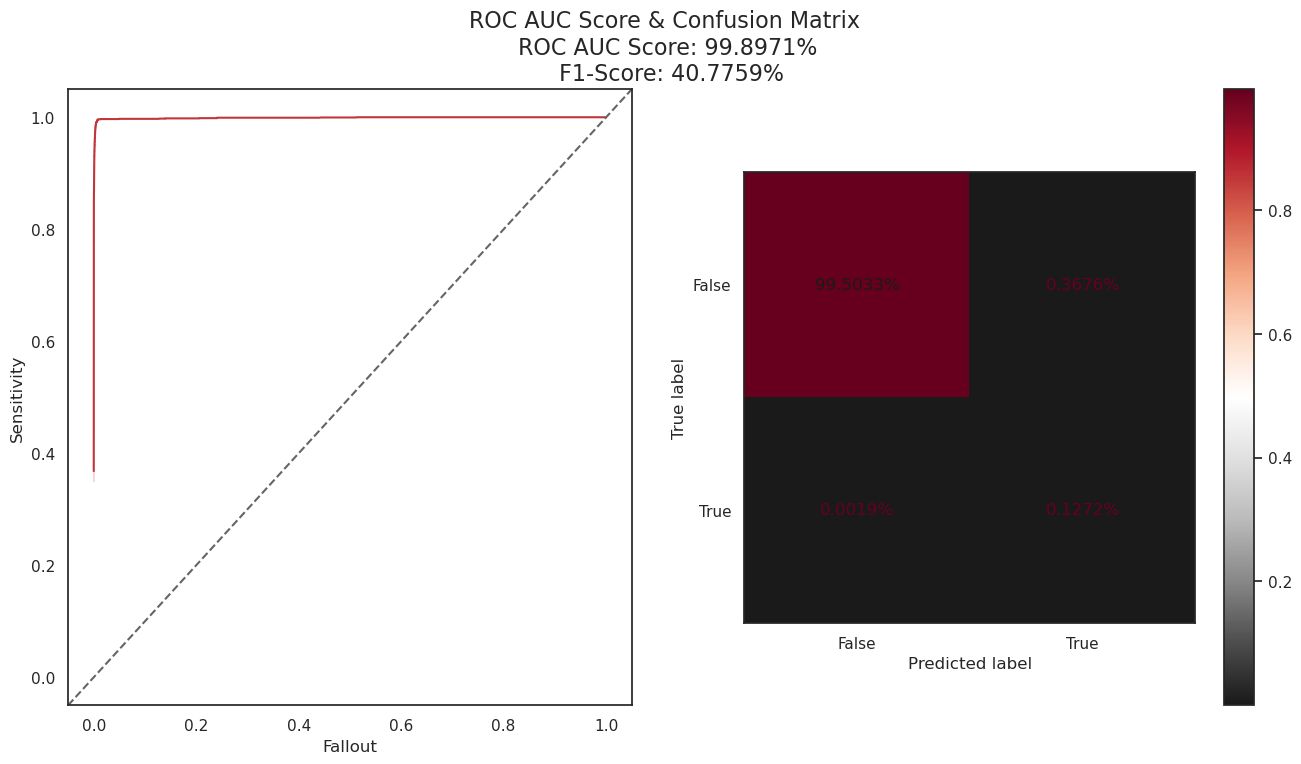

In [5]:
# Creating new thresholds for the model
probs_df = pd.DataFrame(zip(probs[:, 1], y_test), columns=['Probability', 'Actual'])
y_pred_new = probs_df['Probability'].apply(lambda x: True if x > 0.01 else False)

#Visualizing thresholds & new confusion matrix
cm_auc_vis(y_pred=y_pred_new, y_test=y_test, probs=probs)

# 7. Undersampling

Another way to improve model accuracy is through Undersampling.

Undersampling is a data preprocessing technique used to balance imbalanced datasets by reducing the number of instances in the majority class. This technique is particularly beneficial for classification algorithms dealing with imbalanced datasets because it can help prevent bias towards the majority class and improve the model's overall performance. By reducing the number of instances in the majority class, undersampling can ensure that the algorithm receives equal representation of both classes, allowing it to learn from both and make more accurate predictions.

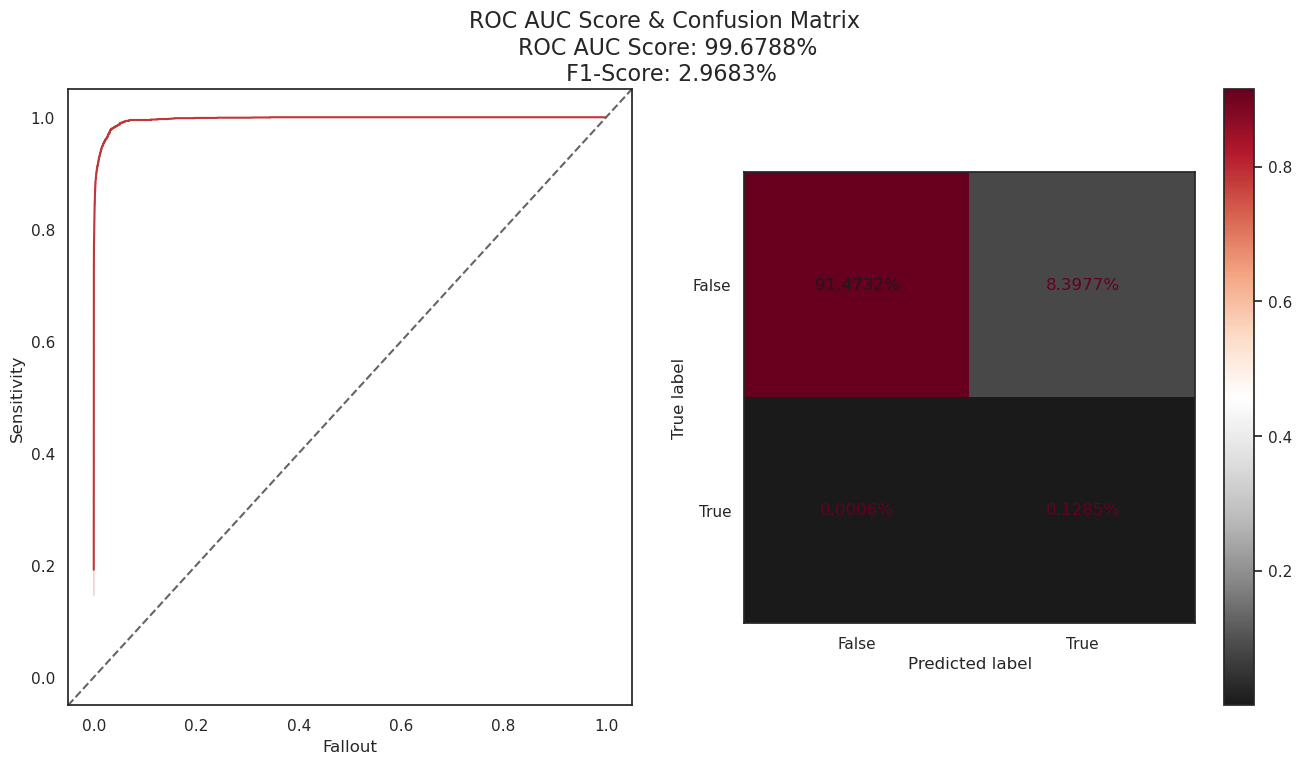

In [6]:
# Rewinding arrays into dataframes with columns
X_train = pd.DataFrame(X_train, columns=X.columns)
y_train = pd.DataFrame(y_train, columns=['Fraud'])

X_y_train = pd.concat([X_train.reset_index(drop = True),
                       y_train.reset_index(drop = True)], axis = 1)

# Creating datasets for defaults and non-defaults
not_fraud = X_y_train[X_y_train['Fraud'] == 0]
fraud = X_y_train[X_y_train['Fraud'] == 1]

# Undersampling the non-defaults
not_fraud_under = not_fraud.sample(len(fraud))

# Concatenating the undersampled nondefaults with defaults
X_y_train_under = pd.concat([not_fraud_under.reset_index(drop = True),
                             fraud.reset_index(drop = True)], axis = 0)

# Creating new independent and dependent variables
X_train_under = X_y_train_under
y_train_under = X_train_under.pop('Fraud')

# Rescaling variables
scaled_X_train_under = mms.fit_transform(X_train_under)

# Fitting the undersampled model
gbt.fit(scaled_X_train_under, y_train_under, eval_set=[(scaled_X_test, y_test)], verbose=False)

# Creating new predictions with the undersampled dataset
y_pred_under = gbt.predict(scaled_X_test)
probs_under = gbt.predict_proba(scaled_X_test)

#Visualizing AUC score and confusion matrix
cm_auc_vis(y_pred=y_pred_under, y_test=y_test, probs=probs_under)

# 8. Undersampling Results

The implementation of undersampling as a technique to balance an imbalanced dataset has been shown to improve the fraud detection capabilities of our classification algorithm. However, it is important to note that this technique has resulted in the mislabeling of numerous regular transactions as fraudulent, which can cause inconvenience to clients. 

At this point, business decisions must be made to determine the appropriate level of stringency in the fraud detection mechanism. This involves evaluating the trade-offs between correctly identifying fraudulent transactions, minimizing the number of fraudulent transactions that go undetected, and minimizing the negative impact on clients who may experience inconvenience or frustration due to misclassification. By carefully considering these factors, businesses can develop a robust fraud detection system that balances the needs of all stakeholders.

# 9. Identifying Feature Importances

As part of the process of validating the accuracy and effectiveness of a model, it is important to identify which features have the greatest impact on its performance. By analyzing feature importances, we can ensure that the model is not assigning undue importance to irrelevant or insignificant variables. Feature importances are determined by evaluating the contribution of each feature to the improvement of the model's performance, and can be visualized through a score system. This score represents the frequency with which the feature has been shown to enhance the model's predictive capabilities. By performing this analysis, we can gain insight into the most critical variables and optimize our model accordingly.

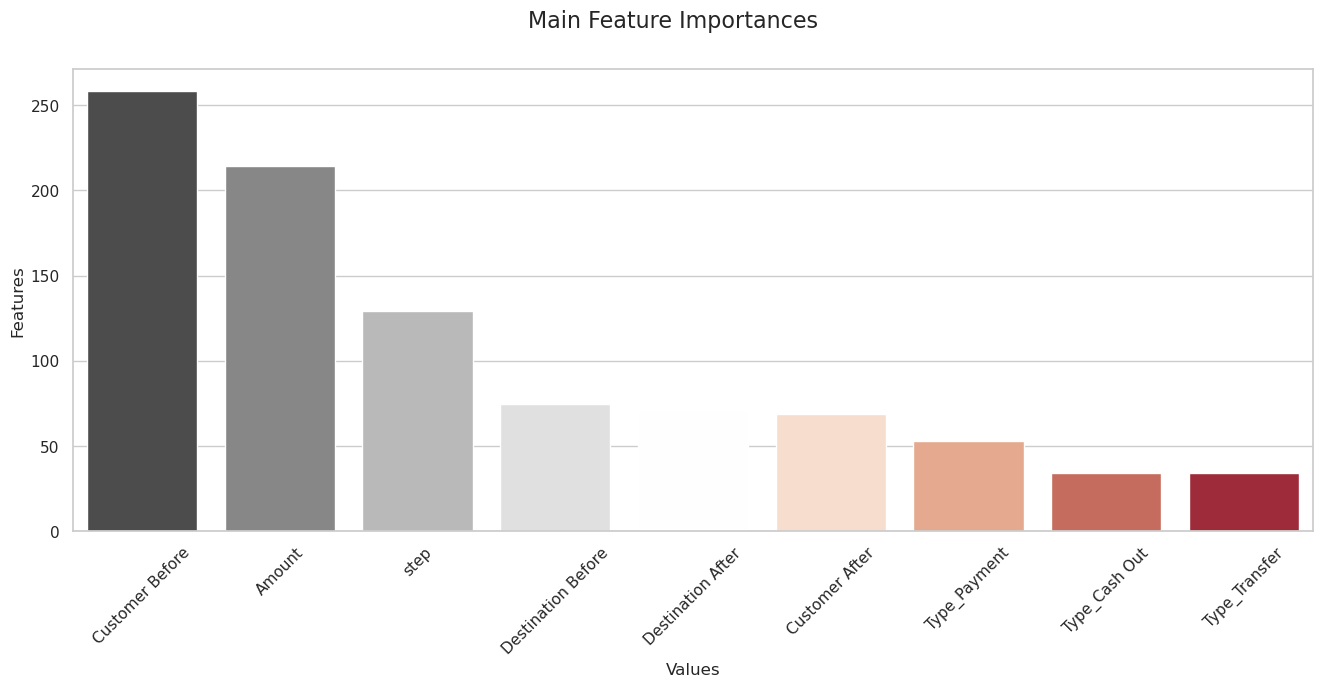

In [7]:
sns.set_style('whitegrid')

# Creating the importances dataframe
importances = pd.DataFrame.from_dict(gbt.get_booster().get_score(importance_type = 'weight'), orient='index')

# Creating a list of features
columns = pd.DataFrame(X.columns)
columns = columns.reset_index()
columns = columns.rename({'index':'code', 
                          0:'feature'}, 
                         axis=1)

columns['code'] = columns['code'].astype('str').apply(lambda x: x.replace(x, f'f{x}'))

# Inner joining the df and list, as XGB does not show
# all features from the original dataset
fts_df = pd.merge(importances, 
                  columns, 
                  left_index=True, 
                  right_on='code', 
                  how='inner')

fts_df = fts_df.rename({0:'value'},  
                       axis=1)
fts_df = fts_df.sort_values('value', 
                            ascending=False)

# Visualizing the main features
fig, ax = plt.subplots(1,1, figsize=(16,6))

fig.suptitle('Main Feature Importances', 
             fontsize=16, 
             font='Verdana')

sns.barplot(data=fts_df.head(15), 
            x='feature', 
            y='value', 
            ax=ax, 
            palette='RdGy_r')

plt.xticks(rotation=45)

ax.set_xlabel('Values')
ax.set_ylabel('Features')
plt.show()